## Prediction of Web Traffic - Time Series Modelling using ARIMA

In [36]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

Given User Session for a date range between October 1st, 2012 to February 12th, 2014

In [4]:
ts = pd.date_range('2012-10-01', periods=len(list_session))

In [5]:
ts

DatetimeIndex(['2012-10-01', '2012-10-02', '2012-10-03', '2012-10-04',
               '2012-10-05', '2012-10-06', '2012-10-07', '2012-10-08',
               '2012-10-09', '2012-10-10',
               ...
               '2014-02-03', '2014-02-04', '2014-02-05', '2014-02-06',
               '2014-02-07', '2014-02-08', '2014-02-09', '2014-02-10',
               '2014-02-11', '2014-02-12'],
              dtype='datetime64[ns]', length=500, freq='D')

In [6]:
ts_df = pd.DataFrame(ts, columns=['date'])
ts_df['user_session'] = list_session
ts_df.set_index('date', inplace = True)

In [7]:
ts_df = ts_df.apply(pd.to_numeric, errors='coerce')
# for converting string type user session values to int values

In [8]:
ts_series = ts_df['user_session']
# All the time series work happens if the df is converted to series, hence assigning a new variable for it

In [11]:
def stationaryTest(ts_df):

    #Determing rolling statistics
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05)
    rolmean = ts_df.rolling(window=5).mean()
    rolstd = ts_df.rolling(window=5).std()

#Plot rolling statistics:
    fig.add_trace(go.Scatter(x=ts_df.reset_index()['date'], y=ts_df.reset_index()['user_session'], name = 'Orginal'), row=1, col=1)
    fig.add_trace(go.Scatter(x=rolmean.reset_index()['date'], y=rolmean.reset_index()['user_session'], name = 'Rolling Mean'), row=2, col=1)
    fig.add_trace(go.Scatter(x=rolstd.reset_index()['date'], y=rolstd.reset_index()['user_session'], name = 'Rolling Std'), row=3, col=1)
    fig.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts_df['user_session'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput[0]<dfoutput[4]:
        print("\nResult: 99% sure that Time Series is Stationary")
    elif dfoutput[0]<dfoutput[5]:
        print("\nResult: 95% sure that Time Series is Stationary")
    elif dfoutput[0]<dfoutput[6]:
        print("\nResult: 90% sure that Time Series is Stationary")
    else:
        print("\nResult: Time Series is not Stationary")
        print("\nExplaination: Time Series can only be said to Stationary if Test Statistics is less than Crtical Value")
        print("\nIf Test Statistics is less than Critical Values of 5% then it means that we are 95% confident that Time Series is Stationary")

In [12]:
stationaryTest(ts_df)

Results of Dickey-Fuller Test:
Test Statistic                  -1.874616
p-value                          0.344095
#Lags Used                      16.000000
Number of Observations Used    483.000000
Critical Value (1%)             -3.443962
Critical Value (5%)             -2.867543
Critical Value (10%)            -2.569967
dtype: float64

Result: Time Series is not Stationary

Explaination: Time Series can only be said to Stationary if Test Statistics is less than Crtical Value

If Test Statistics is less than Critical Values of 5% then it means that we are 95% confident that Time Series is Stationary


#### Trying out with Log and differencing for elimination of trend and seasonality

In [14]:
ts_removing_trend = np.log(ts_series)    # Eliminating Trend
ts_removing_seasonality = ts_removing_trend - ts_removing_trend.shift()    #Eliminating Seasonality

In [15]:
ts_diff = pd.DataFrame(ts_removing_seasonality)

In [16]:
go.Figure([go.Scatter(x=ts_diff.reset_index()['date'], y=ts_diff.reset_index()['user_session'])])

#Now this waveform looks pretty stationary after removing trend and seasonality, lets check further what does stationaryTest has to say about it

In [17]:
ts_removing_seasonality.dropna(inplace=True)

In [18]:
ts_diff.dropna(inplace=True)
stationaryTest(ts_diff)

Results of Dickey-Fuller Test:
Test Statistic                -6.701169e+00
p-value                        3.886011e-09
#Lags Used                     1.800000e+01
Number of Observations Used    4.800000e+02
Critical Value (1%)           -3.444047e+00
Critical Value (5%)           -2.867580e+00
Critical Value (10%)          -2.569987e+00
dtype: float64

Result: 99% sure that Time Series is Stationary


#### Trying out with log and decomposing - Another way of making the Time Series Stationary

In [19]:
decomposition = seasonal_decompose(ts_removing_trend)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

ts_decompose = residual

In [20]:
df_decompose = pd.DataFrame(ts_decompose)

In [21]:
df_decompose.dropna(inplace = True)
stationaryTest(df_decompose)

Results of Dickey-Fuller Test:
Test Statistic                -9.699800e+00
p-value                        1.079817e-16
#Lags Used                     1.800000e+01
Number of Observations Used    4.750000e+02
Critical Value (1%)           -3.444192e+00
Critical Value (5%)           -2.867644e+00
Critical Value (10%)          -2.570021e+00
dtype: float64

Result: 99% sure that Time Series is Stationary


### ARIMA Modelling

In [37]:
lag_acf = acf(ts_removing_seasonality, nlags=6)
lag_pacf = pacf(ts_removing_seasonality, nlags=6, method='ols')

In [23]:
matplotlib.rcParams['figure.figsize'] = (10,5)

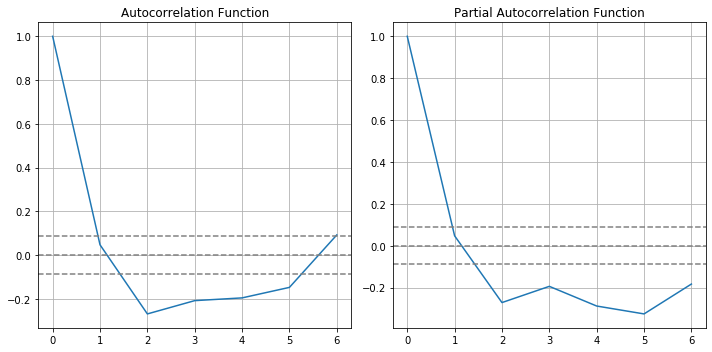

In [26]:
plt.subplot(121)
plt.grid()
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_removing_seasonality)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_removing_seasonality)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.grid()
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_removing_seasonality)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_removing_seasonality)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Text(0.5, 1.0, 'RSS: 12.3873')

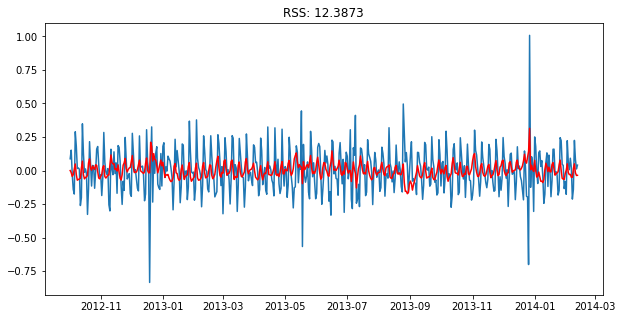

In [38]:
model = ARIMA(ts_removing_trend, order=(1,1,1))  
results = model.fit(disp=0)  
plt.plot(ts_removing_seasonality)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-ts_removing_seasonality)**2))

In [29]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.user_session   No. Observations:                  499
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 214.032
Method:                       css-mle   S.D. of innovations              0.158
Date:                Mon, 14 Oct 2019   AIC                           -420.064
Time:                        17:03:00   BIC                           -403.214
Sample:                    10-02-2012   HQIC                          -413.452
                         - 02-12-2014                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0002      0.002      0.106      0.915      -0.004       0.004
ar.L1.D.user_session     0.6134      0.050     12.221      0.000       0.515       0.712
ma.L1.D.user_session    -0.8834      0.026    -33.629      0.000      -0.935      -0.832
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6302           +0.0000j            1.6302            0.0000
MA.1            1.1320           +0.0000j            1.1320            0.0000
-----------------------------------------------------------------------------
"""

### Prediction

Predicting the future and checking the error that model made in prediction when compared with original values

In [41]:
size = int(len(ts_removing_trend)-15)
train_arima, test_arima = ts_removing_trend[0:size], ts_removing_trend[size:len(ts_removing_trend)]
train_values = [x for x in train_arima]

predictions = []
original = []
error_list = []

for t in range(len(test_arima)):
    model = ARIMA(train_values, order=(1, 1, 1))
    model_fit = model.fit(disp=0)
    
    output = model_fit.forecast()
    predictive_val = output[0]
    original_val = test_arima[t]
    train_values.append(original_val)
    predictive_val = np.exp(predictive_val)
    original_val = np.exp(original_val)
    
    error = ((abs(predictive_val - original_val)) / original_val) * 100
    error_list.append(error)
    print('predicted = %f,   expected = %f,   error = %f ' % (predictive_val, original_val, error), '%')
    
    predictions.append(float(predictive_val))
    original.append(float(original_val))
    
print('\n Means Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')

predicted = 1706.283214,   expected = 1890.000000,   error = 9.720465  %
predicted = 1768.800453,   expected = 1652.000000,   error = 7.070245  %
predicted = 1614.754452,   expected = 1521.000000,   error = 6.164001  %
predicted = 1523.841147,   expected = 1274.000000,   error = 19.610765  %
predicted = 1337.592754,   expected = 1592.000000,   error = 15.980355  %
predicted = 1566.086174,   expected = 1694.000000,   error = 7.550993  %
predicted = 1642.147417,   expected = 1705.000000,   error = 3.686369  %
predicted = 1656.088359,   expected = 1869.000000,   error = 11.391741  %
predicted = 1777.711437,   expected = 1910.000000,   error = 6.926103  %
predicted = 1817.298548,   expected = 1544.000000,   error = 17.700683  %
predicted = 1563.970482,   expected = 1341.000000,   error = 16.627180  %
predicted = 1408.141477,   expected = 1679.000000,   error = 16.132134  %
predicted = 1650.776445,   expected = 1823.000000,   error = 9.447260  %
predicted = 1756.786444,   expected = 1845.00

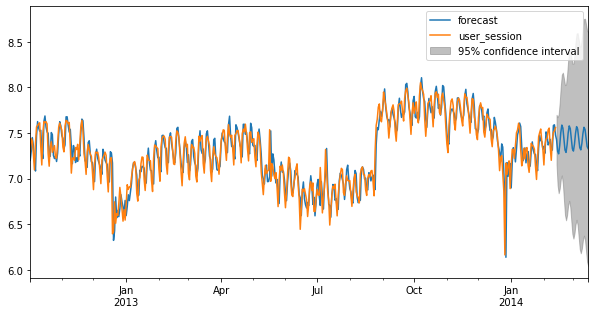

In [35]:
results.plot_predict(1,530)
plt.show()

#showcasing the forecasting for next 30 days